https://www.microsoft.com/en-us/download/details.aspx?id=54765
^ site used to download dataset

In [1]:
# GOAL: create and train a model on multiple Franklin's
# this is the most recent version I've been working on (there are other copies without callbacks, without fine tuning, etc)

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
from PIL import Image

In [5]:
import glob

In [6]:
import numpy as np
from numpy import asarray
from numpy import argmax

In [7]:
import os
import random

In [8]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [9]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [10]:
datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
trainGen = datagen.flow_from_directory(
directory = '/Users/kaylaneal/Downloads/alzResearch/cats_and_dogs_filtered/train',
class_mode = 'categorical',
color_mode = 'rgb',
target_size = IMG_SIZE,
batch_size = BATCH_SIZE)
trainGen.class_indices

Found 2028 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [12]:
validGen = datagen.flow_from_directory(
directory = '/Users/kaylaneal/Downloads/alzResearch/cats_and_dogs_filtered/validation',
class_mode = 'categorical',
color_mode = 'rgb',
target_size = IMG_SIZE,
batch_size = BATCH_SIZE)
validGen.class_indices

Found 1000 images belonging to 2 classes.


{'cats': 0, 'dogs': 1}

In [13]:
testGen = datagen.flow_from_directory(
directory = '/Users/kaylaneal/Downloads/alzResearch/frankphotos/',
class_mode = 'categorical',
color_mode = 'rgb',
target_size = IMG_SIZE,
batch_size = BATCH_SIZE)

Found 80 images belonging to 1 classes.


In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [16]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (160, 160, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
imgBatch, labelBatch = next(iter(testGen))
featureBatch = base_model(imgBatch)
featureBatch.shape

TensorShape([32, 5, 5, 1280])

In [18]:
base_model.trainable = False #freezes convolutional base

In [19]:
globalAvLayer = tf.keras.layers.GlobalAveragePooling2D()
featureBatchAv = globalAvLayer(featureBatch)
featureBatchAv.shape
# add classification head

TensorShape([32, 1280])

In [20]:
predLayer = tf.keras.layers.Dense(1)
predBatch = predLayer(featureBatchAv)
predBatch.shape
# convert features to single prediction

TensorShape([32, 1])

In [21]:
# build model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(inputs)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
x = norm_layer(x)
x = base_model(x, training=False)
x = globalAvLayer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = predLayer(x)
outputs = Dense(2, activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
#model.summary()

In [24]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', patience = 8)]

In [25]:
initial_epochs = 30

In [26]:
history = model.fit(trainGen,
                    epochs=initial_epochs,
                    validation_data=validGen,
                   callbacks = callbacks)

Epoch 1/30
64/64 [==============================] - 53s 775ms/step - loss: 1.0146 - accuracy: 0.5161 - val_loss: 0.6921 - val_accuracy: 0.5080
Epoch 2/30
64/64 [==============================] - 44s 685ms/step - loss: 0.7410 - accuracy: 0.4890 - val_loss: 0.6910 - val_accuracy: 0.5380
Epoch 3/30
64/64 [==============================] - 41s 635ms/step - loss: 0.7545 - accuracy: 0.4876 - val_loss: 0.6914 - val_accuracy: 0.5100
Epoch 4/30
64/64 [==============================] - 40s 626ms/step - loss: 0.7335 - accuracy: 0.4999 - val_loss: 0.6910 - val_accuracy: 0.5150
Epoch 5/30
64/64 [==============================] - 39s 615ms/step - loss: 0.7185 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 6/30
64/64 [==============================] - 43s 665ms/step - loss: 0.7264 - accuracy: 0.5229 - val_loss: 0.6906 - val_accuracy: 0.4980
Epoch 7/30
64/64 [==============================] - 43s 675ms/step - loss: 0.7212 - accuracy: 0.5017 - val_loss: 0.6898 - val_accuracy: 0.5210

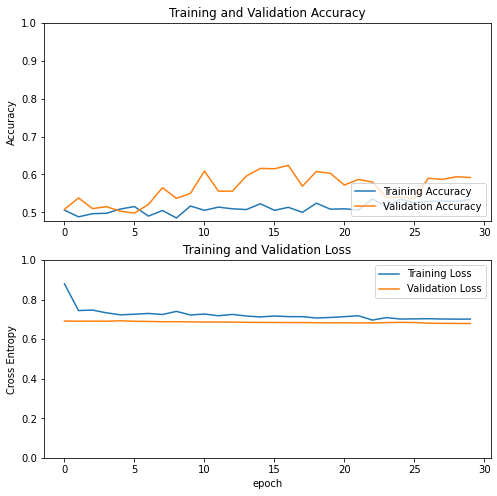

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
def prospic(path):
    image = load_img(path, grayscale = False, color_mode = "rgb", target_size = (160,160))
    image = img_to_array(image)
    image = np.reshape(image,(image.shape[0], image.shape[1], image.shape[2]))
    image = image.astype('float32') / 225.0
    return image

In [29]:
trainImg = list(glob.glob((r'/Users/kaylaneal/Downloads/alzResearch/cats_and_dogs_filtered/train/dog') +'*/*'))

In [30]:
cat = 0
dog = 0
for im in trainImg:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    #imgplot = plt.imshow(image)
    #plt.show()
    if (argmax(yhat) == 1):
        cat += 1
    else:
        dog += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", dog, " / ", (cat+dog))

Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: c

Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: c

Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: c

In [31]:
ctrainImg = list(glob.glob((r'/Users/kaylaneal/Downloads/alzResearch/cats_and_dogs_filtered/train/cat') +'*/*'))

In [32]:
cat = 0
dog = 0
for im in ctrainImg:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    #img = mpimg.imread('your_image.png')
    #imgplot = plt.imshow(image)
    #plt.show()
    if (argmax(yhat) == 1):
        cat += 1
    else:
        dog += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", cat, "/", (cat+dog))

Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: c

Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: c

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: c

In [33]:
frankImages = list(glob.glob((r'/Users/kaylaneal/Downloads/alzResearch/frankphotos/dog') +'*/*'))

In [34]:
cat = 0
dog = 0

for im in frankImages:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    if (argmax(yhat) == 1):
        cat += 1
    else:
        dog += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", dog, "/", (cat+dog))

Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=0
Predicted: class=0
Predicted: class=1
Predicted: class=0
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: class=1
Predicted: c

In [35]:
# fine tuning:

In [36]:
base_model.trainable = True

In [37]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [38]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [39]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(trainGen,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validGen)

Epoch 30/40
64/64 [==============================] - 61s 904ms/step - loss: 0.7357 - accuracy: 0.5125 - val_loss: 0.6919 - val_accuracy: 0.5030
Epoch 31/40
64/64 [==============================] - 58s 901ms/step - loss: 0.6963 - accuracy: 0.5034 - val_loss: 0.7028 - val_accuracy: 0.5000
Epoch 32/40
64/64 [==============================] - 62s 975ms/step - loss: 0.6964 - accuracy: 0.5073 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 33/40
64/64 [==============================] - 60s 947ms/step - loss: 0.6966 - accuracy: 0.4879 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 34/40
64/64 [==============================] - 59s 931ms/step - loss: 0.6983 - accuracy: 0.4936 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 35/40
64/64 [==============================] - 62s 962ms/step - loss: 0.6946 - accuracy: 0.4966 - val_loss: 0.6930 - val_accuracy: 0.5050
Epoch 36/40
64/64 [==============================] - 52s 820ms/step - loss: 0.6944 - accuracy: 0.4936 - val_loss: 0.7021 - val_accuracy:

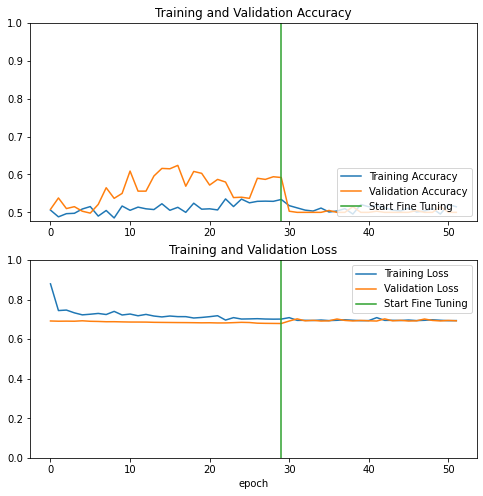

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
cat = 0
dog = 0
for im in trainImg:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    #imgplot = plt.imshow(image)
    #plt.show()
    if (argmax(yhat) == 1):
        dog += 1
    else:
        cat += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", dog, " / ", (cat+dog))

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

In [42]:
cat = 0
dog = 0
for im in ctrainImg:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    #img = mpimg.imread('your_image.png')
    #imgplot = plt.imshow(image)
    #plt.show()
    if (argmax(yhat) == 1):
        dog += 1
    else:
        cat += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", cat, "/", (cat+dog))

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

In [43]:
cat = 0
dog = 0

for im in frankImages:
    image = prospic(im)
    yhat = model.predict(np.array([image]))
    if (argmax(yhat) == 1):
        dog += 1
    else:
        cat += 1
    print('Predicted: class=%d' % argmax(yhat))
    
print("correct: ", dog, "/", (cat+dog))

Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: class=0
Predicted: c

In [ ]:
model.save('tlftFrank.h5')